<a href="https://colab.research.google.com/github/khchoi-physik/pbh_simulations/blob/main/wpca_analysis_smaller_box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wpca

^C


## Single run WPCA Analysis

In [1]:
# @title Import packages

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from wpca import WPCA

import time
import gc
import os
import glob

#from scipy.special import erf

In [2]:
# @title 1.31 CPU sampling
class CPU_SAMPLING:

    def __init__(self, exprf, pixel, z_pixel):
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.exprf = exprf


    def max_sub_exprfs(self, lx, ly, lz, x, y, z):

        x_min, x_max = max(x-lx,0), min(x+lx +1, self.pixel)
        y_min, y_max = max(y-ly,0), min(y+ly +1, self.pixel)
        z_min, z_max = max(z-lz,0), min(z+lz +1, self.z_pixel)

        sub_exprf = self.exprf[x_min:x_max, y_min:y_max, z_min:z_max]
        max_sub_exprf = np.max(sub_exprf)

        del sub_exprf

        return np.max(max_sub_exprf)

    def sub_exprfs(self, lx, ly, lz, x, y, z):

        x_min, x_max = max(x-lx,0), min(x+lx +1, self.pixel)
        y_min, y_max = max(y-ly,0), min(y+ly +1, self.pixel)
        z_min, z_max = max(z-lz,0), min(z+lz +1, self.z_pixel)

        return self.exprf[x_min:x_max, y_min:y_max, z_min:z_max]

In [3]:
def white_noise_samples(wn_directory):

    a13_list = []
    a32_list = []

    print(f'Current Working Directory: {os.getcwd()}')
    os.chdir(f'{wn_directory}')
    print(f'Changed Working Directory: {os.getcwd()}')

    npy_files = glob.glob('*ev.npy')

    for files in npy_files:
        ev_list = np.load(f'{files}')

        for mm in range(len(ev_list)):
            a13_list.append(ev_list[mm][0]/ev_list[mm][2]);
            a32_list.append(ev_list[mm][2]/ev_list[mm][1]);

    return a13_list, a32_list

In [4]:
# @title Paramters

k_power =  3
bl= 32
pixel = 2**9
z_pixel = pixel
g_sigma = 7

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_{k_power}_l_{bl}_s_{g_sigma}'
os.chdir(folder_path)
os.getcwd()


npy_files = glob.glob('*0.npy')
len(npy_files)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


290

In [ ]:
l_list = [5,6,7,8,9,10]

for l in l_list:
    lengths = 2*l + 1

    lx,ly,lz = l,l,l

    #folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results'
    #os.chdir(folder_path)
    #print("Current Working Directory:", os.getcwd() )
    #white_noise_samples = np.load(f'wpca_whitenoise_ratio_l_{l}.npy')

    folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_{k_power}_l_{bl}_s_{g_sigma}'
    os.chdir(folder_path)
    npy_files = glob.glob('*0.npy')

    WPCA13_list = []
    WPCA32_list = []

    for files in npy_files:

        st = time.time()
        wpca_ev_list = []
        wpca_vec_list = []

        sub_exprf = np.load(f'{files}')

        max_pt = np.argmax( sub_exprf )
        max_coord = np.unravel_index(max_pt, sub_exprf.shape)

        x,y,z = max_coord[0], max_coord[1], max_coord[2]

        x_min, x_max = max(x-lx,0), min(x+lx +1, pixel)
        y_min, y_max = max(y-ly,0), min(y+ly +1, pixel)
        z_min, z_max = max(z-lz,0), min(z+lz +1, z_pixel)

        max_sub_vol = sub_exprf[x_min:x_max, y_min:y_max, z_min:z_max]

        if max_sub_vol.shape == (lengths, lengths, lengths):
            coords = np.where( max_sub_vol > 0)
            total_mass = np.sum(max_sub_vol)
            amps, coords = max_sub_vol[coords], np.array(coords).T
            amps = amps/total_mass

            #coord_amp = np.array( [(coord[0],coord[1],coord[2], amp ) for coord, amp in zip(coords, amps)]) #Normalized amplitudes. Threshold = 0, Max Pt. = 1.

            weights = np.zeros_like(coords, dtype=np.float64)
            for nn in range(amps.shape[0]):
                weights[nn] = np.array( [amps[nn],amps[nn],amps[nn] ])

            wpca = WPCA(n_components=3)
            wpca.fit(X = coords, weights=weights )

            wpca_ev_list.append(wpca.explained_variance_ratio_)
            wpca_vec_list.append(wpca.components_)

            wpca_ev1 = wpca.explained_variance_ratio_[0]
            wpca_ev2 = wpca.explained_variance_ratio_[1]
            wpca_ev3 = wpca.explained_variance_ratio_[2]
            WPCA13_list.append( wpca_ev1 / wpca_ev3 )
            WPCA32_list.append( wpca_ev3 / wpca_ev2 )

        #print(round(time.time()- st,2), f'{files}')

    white_noise_directory =  f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results/wpca_white_noise/l_{l}'
    a13, a32 = white_noise_samples(white_noise_directory)

    plt.figure(figsize=(6,4))
    plt.hist(WPCA13_list, bins=401, density =True, color= 'blue', alpha = 0.6);
    plt.hist(WPCA32_list, bins=401, density =True, color= 'red', alpha = 0.6);
    plt.hist(a13, bins=401, density =True, color= 'black', alpha = 0.2);
    plt.hist(a32, bins=401, density =True, color= 'black', alpha = 0.2);

    plt.title(f'Non-sphericity analysis of box size {2*l +1}')
    plt.legend(['A13 : Non-sphericity','A32 : Shapes','A13 : James Sphericity Hypothesis'], fontsize =11)
    plt.xlabel(f'Ratio of explained varience ratio', fontsize =14)
    plt.ylabel(f'Prob. Density', fontsize =14)
    #plt.xlim([0, 3])

    folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results'
    os.chdir(folder_path)
    print("Current Working Directory:", os.getcwd() )
    plt.savefig(f'Non_Sphericity_k_{k_power}_s_{g_sigma}_l_{l}', bbox_inches='tight', pad_inches=0)
    plt.show()

## Mult-run WPCA Analysis of DIfferent Sigmas

In [1]:
# @title Import packages

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from wpca import WPCA

import time
import gc
import os
import glob

import multiprocessing

#from scipy.special import erf

In [12]:
k_power = 2
bl= 32 # max length


pixel = 2**9
z_pixel = pixel
g_sigma = 7

l_list = [5,9,20,32]
#l_list = [5,9]
s_list = [6,7]

11
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_2_l_32_s_6
Changed Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/wpca_white_noise/l_5
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_2_l_32_s_7
Changed Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/wpca_white_noise/l_5
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/visualizations/k_2


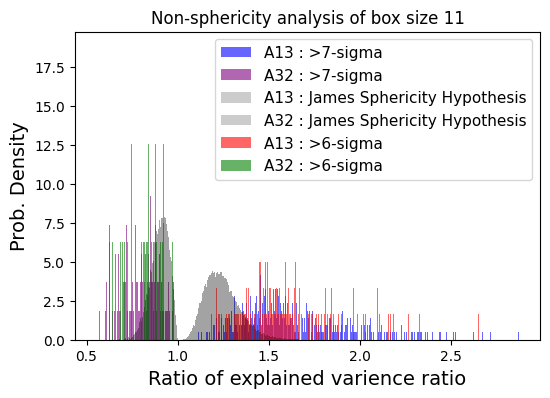

19
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_2_l_32_s_6
Changed Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/wpca_white_noise/l_9
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_2_l_32_s_7
Changed Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/wpca_white_noise/l_9
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/visualizations/k_2


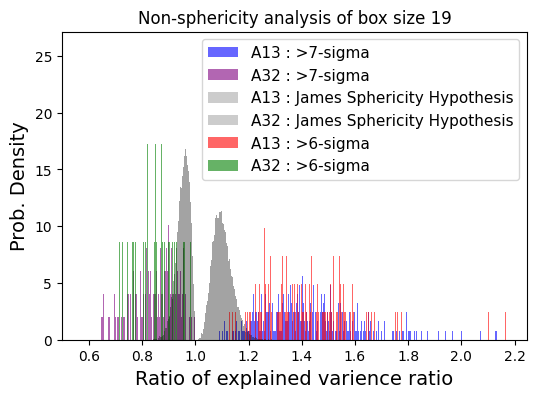

41
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_2_l_32_s_6
Changed Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/wpca_white_noise/l_20
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_2_l_32_s_7
Changed Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/wpca_white_noise/l_20
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/visualizations/k_2


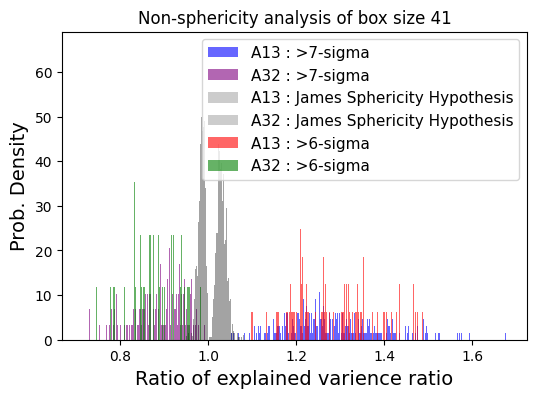

65
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_2_l_32_s_6
Changed Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/wpca_white_noise/l_32
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_2_l_32_s_7
Changed Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/wpca_white_noise/l_32
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/visualizations/k_2


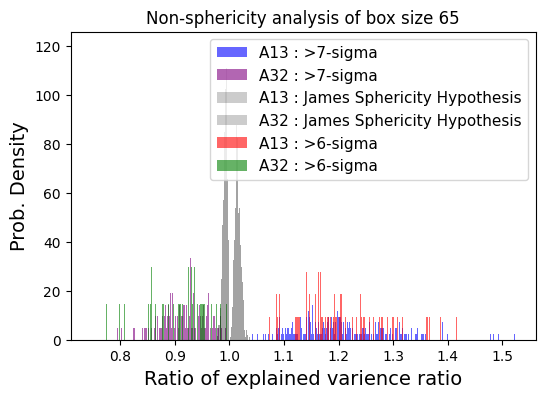

In [13]:
for l in l_list:
    plt.figure(figsize=(6,4))
    lengths = int(2*l +1)
    lx,ly,lz = l,l,l

    print(lengths)

    for g_sigma in s_list:

        folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_{k_power}_l_{bl}_s_{g_sigma}'  # bl = max length is needed here
        os.chdir(folder_path)

        if g_sigma > 6:
            npy_files = glob.glob('*.npy')
        else:
            npy_files = glob.glob('*0.npy')

        WPCA13_list = []
        WPCA32_list = []

        for files in npy_files:

            st = time.time()
            wpca_ev_list = []
            wpca_vec_list = []

            sub_exprf = np.load(f'{files}')

            max_pt = np.argmax( sub_exprf )
            max_coord = np.unravel_index(max_pt, sub_exprf.shape)

            x,y,z = max_coord[0], max_coord[1], max_coord[2]

            x_min, x_max = max(x-lx,0), min(x+lx +1, pixel)
            y_min, y_max = max(y-ly,0), min(y+ly +1, pixel)
            z_min, z_max = max(z-lz,0), min(z+lz +1, z_pixel)

            max_sub_vol = sub_exprf[x_min:x_max, y_min:y_max, z_min:z_max]

            if max_sub_vol.shape == (lengths, lengths, lengths):

                coords = np.where( max_sub_vol > 0)
                total_mass = np.sum(max_sub_vol)
                amps, coords = max_sub_vol[coords], np.array(coords).T
                amps = amps/total_mass

                weights = np.zeros_like(coords, dtype=np.float64)
                for nn in range(amps.shape[0]):
                    weights[nn] = np.array( [amps[nn],amps[nn],amps[nn]])

                wpca = WPCA(n_components=3)
                wpca.fit(X = coords, weights=weights )

                wpca_ev_list.append(wpca.explained_variance_ratio_)
                wpca_vec_list.append(wpca.components_)

                wpca_ev1 = wpca.explained_variance_ratio_[0]
                wpca_ev2 = wpca.explained_variance_ratio_[1]
                wpca_ev3 = wpca.explained_variance_ratio_[2]
                WPCA13_list.append( wpca_ev1 / wpca_ev3 )
                WPCA32_list.append( wpca_ev3 / wpca_ev2 )

                #print(round(time.time()- st,2), f'{files}')

        if g_sigma == 7:
            plt.hist(WPCA13_list, bins=401, density =True, color= 'red', alpha = 0.6);
            plt.hist(WPCA32_list, bins=401, density =True, color= 'green', alpha = 0.6);
        if g_sigma == 6:
            plt.hist(WPCA13_list, bins=401, density =True, color= 'blue', alpha = 0.6);
            plt.hist(WPCA32_list, bins=401, density =True, color= 'purple', alpha = 0.6);

        white_noise_directory =  f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results/wpca_white_noise/l_{l}'
        a13, a32 = white_noise_samples(white_noise_directory)
        plt.hist(a13, bins=401, density =True, color= 'black', alpha = 0.2);
        plt.hist(a32, bins=401, density =True, color= 'black', alpha = 0.2);

    plt.legend(['A13 : >7-sigma',
                'A32 : >7-sigma',
                'A13 : James Sphericity Hypothesis',
                'A32 : James Sphericity Hypothesis',
                'A13 : >6-sigma',
                'A32 : >6-sigma'] , fontsize =11)
    plt.xlabel(f'Ratio of explained varience ratio', fontsize =14)
    plt.ylabel(f'Prob. Density', fontsize =14)
    plt.title(f'Non-sphericity analysis of box size {2*l +1}')

    folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results/visualizations/k_{k_power}'
    os.chdir(folder_path)
    print("Current Working Directory:", os.getcwd() )


    plt.savefig(f'Non_Sphericity_k_{k_power}_l_{l}_diffs', bbox_inches='tight', pad_inches=0)
    plt.show()